In [1]:
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

import sccoda.datasets as scd

import scanpy as sc
import pertpy as pt


os.chdir('/root/host_home')

2025-07-18 08:48:29.439478: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import session_info
session_info.show(excludes=['pybind11_abseil'])

# Filenames

In [2]:
adata_input = 'lp_NPCs/processed_data/lp_NPC_clustered_scvi_cuda.h5ad'

# Read in data

In [3]:
adata = sc.read(adata_input)

In [4]:
adata

AnnData object with n_obs × n_vars = 30843 × 17250
    obs: 'Donor', 'lane', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'doublet_score', 'size_factors', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'Ferroptosis_pos_corr', 'Ferroptosis_neg_corr', 'Apoptosis_pos_corr', 'Apoptosis_neg_corr', 'Necroptosis_pos_corr', 'Autophagy_pos_corr', 'Pathanatos_pos_corr', 'cell_types', 'cell_types_abbrev'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_genes', 'highly_variable_nbatches', '

In [5]:
pd.crosstab(adata.obs['condition'], adata.obs['Donor'])

Donor,UKERi1JF-R1-018,UKERiG3G-R1-039,UKERi1E4-R1-003,UKERiO3H-R1-005,UKERi82A-R1-002,UKERiJ2C-R1-015,UKERiM89-R1-005,UKERiC99-R1-007,UKERiR66-R1-007,UKERiAY6-R1-003,UKERiPX7-R1-001,UKERi88H-R1-002
condition,,,,,,,,,,,,
Control,1498,2042,2406,3256,2496,0,0,0,0,0,0,0
Parkinson,0,0,0,0,0,1686,2143,2051,2340,2591,5354,2980


# Compositional analysis - cell_types

## Build model

In [28]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    adata,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="cell_types",
    sample_identifier="Donor",
    covariate_obs=["condition"],
)
sccoda_data

MuData object with n_obs × n_vars = 30855 × 17259
  var:	'n_cells'
  2 modalities
    rna:	30843 x 17250
      obs:	'Donor', 'lane', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'doublet_score', 'size_factors', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'Ferroptosis_pos_corr', 'Ferroptosis_neg_corr', 'Apoptosis_pos_corr', 'Apoptosis_neg_corr', 'Necroptosis_pos_corr', 'Autophagy_pos_corr', 'Pathanatos_pos_corr', 'cell_types', 'cell_types_abbrev'
      var:	'gene_ids', 'feature_types', 'genome', 'gene_symbols', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_genes', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable_genes_batch_aware'
      uns:	'Donor_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_types_abbrev_colors', 'cell_types_colors', 'condition_colors', 'gender_colors', 'hvg', 'lane_colors', 'neighbors', 'neighbors_CC', 'neighbors_noCC', 'pca', 'phase_colors', 'umap'
      obsm:	'X_pca', 'X_scVI_CC', 'X_scVI_noCC', 'X_umap', 'X_umap_CC', 'X_umap_noCC', '_scvi_extra_continuous_covs'
      varm:	'PCs'
      layers:	'counts', 'log1p_norm', 'scran_normalization', 'soupX_counts'
      obsp:	'connectivities', 'connectivities_CC', 'connectivities_noCC', 'distances', 'distances_CC', 'distances_noCC'
    coda:	12 x 9
      obs:	'condition', 'age', 'gender', 'cultivation_period', '_scvi_batch', '_scvi_labels'
      var:	'n_cells'

In [30]:
sccoda_data.mod['coda'].obs['Donor'] = sccoda_data.mod['coda'].obs_names

In [31]:
sccoda_data.mod['coda'].obs

,condition,age,gender,cultivation_period,_scvi_batch,_scvi_labels,Donor
Donor,,,,,,,
UKERi1JF-R1-018,Control,42.0,M,lp,1,0,UKERi1JF-R1-018
UKERiG3G-R1-039,Control,69.0,F,lp,6,0,UKERiG3G-R1-039
UKERi1E4-R1-003,Control,53.0,M,lp,0,0,UKERi1E4-R1-003
UKERiO3H-R1-005,Control,71.0,M,lp,9,0,UKERiO3H-R1-005
UKERi82A-R1-002,Control,66.0,F,lp,2,0,UKERi82A-R1-002
UKERiJ2C-R1-015,Parkinson,73.0,M,lp,7,0,UKERiJ2C-R1-015
UKERiM89-R1-005,Parkinson,64.0,M,lp,8,0,UKERiM89-R1-005
UKERiC99-R1-007,Parkinson,68.0,M,lp,5,0,UKERiC99-R1-007
UKERiR66-R1-007,Parkinson,54.0,M,lp,11,0,UKERiR66-R1-007


## Visualize distribution

In [7]:
if not os.path.exists('lp_NPCs/figures/Composition'):
    # Create a new directory because it does not exist
    os.mkdir('lp_NPCs/figures/Composition')
    print("The new directory: lp_NPCs/figures/Composition is created!")
else: 
    print("The directory (lp_NPCs/figures/Composition) already exists")

The directory (lp_NPCs/figures/Composition) already exists


/usr/local/lib/python3.10/dist-packages/pertpy/tools/_coda/_base_coda.py:1711: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cell_types, rotation=90)


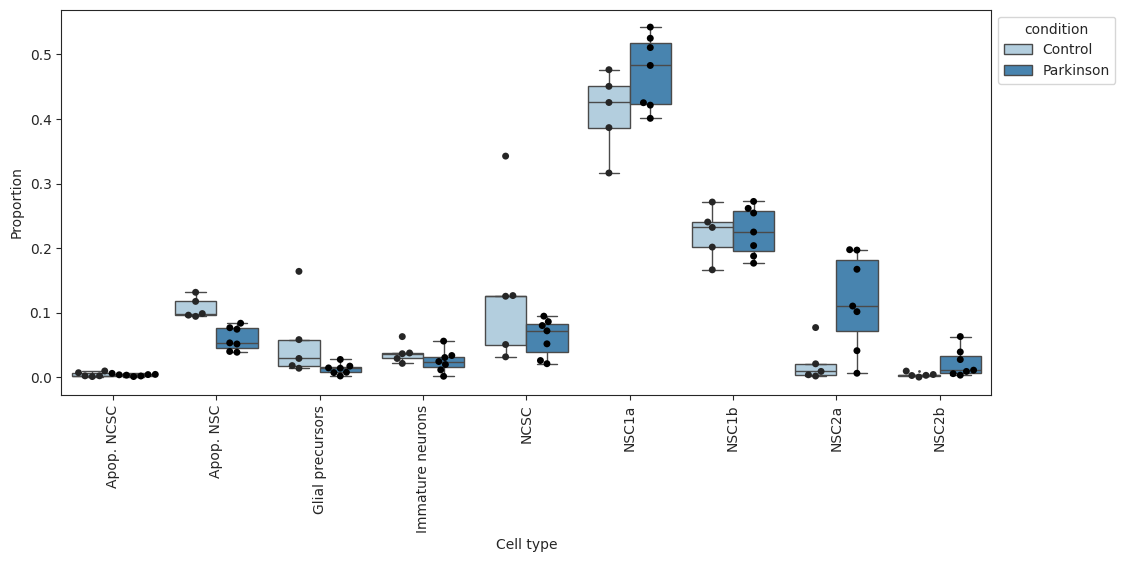

In [9]:
#Show an overview about cell type distributions across conditions as boxplot
pt.pl.coda.boxplots(
    sccoda_data,
    modality_key="coda",
    feature_name="condition",
    figsize=(12, 5),
    add_dots=True,

    plot_facets = False
)
plt.savefig('lp_NPCs/figures/Composition/celltype_composition.pdf', bbox_inches='tight')
plt.show()

In [10]:
col6 = adata.uns['cell_types_colors']

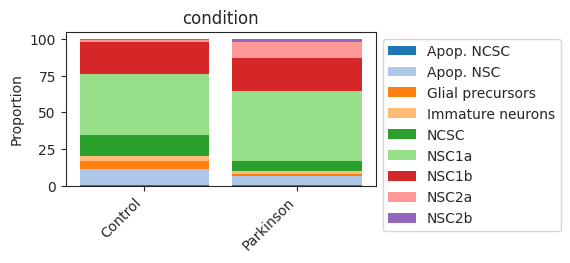

In [11]:
#Show an overview about cell type distributions across conditions as stacked barplot
pt.pl.coda.stacked_barplot(
    sccoda_data, modality_key="coda", feature_name="condition", figsize=(4, 2)
)
plt.show()

In [14]:
sccoda_data.obs

,rna:Donor,rna:lane,rna:condition,rna:age,rna:years_of_illness,rna:deltaHY,rna:deltaUPDRS,rna:deltaADL,rna:deltaDOPA,rna:gender,...,rna:Autophagy_pos_corr,rna:Pathanatos_pos_corr,rna:cell_types,rna:cell_types_abbrev,coda:condition,coda:age,coda:gender,coda:cultivation_period,coda:_scvi_batch,coda:_scvi_labels
AAACCCAAGACTCTAC-23L013539,UKERiC99-R1-007,23L013539,Parkinson,68.0,7.0,2.5,36.0,-0.5,610.0,M,...,0.297097,-0.382015,NSC1a,NSC1a,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGATCACCT-23L013539,UKERiG3G-R1-039,23L013539,Control,69.0,NaN,NaN,NaN,NaN,NaN,F,...,-0.204648,0.306933,NSC1b,NSC1b,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCACAATAGAGT-23L013539,UKERiAY6-R1-003,23L013539,Parkinson,37.0,4.0,1.0,-1.0,-0.2,800.0,M,...,0.080003,-0.049069,NSC2a,NSC2a,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCACAGGTTACT-23L013539,UKERiPX7-R1-001,23L013539,Parkinson,49.0,1.0,1.0,0.0,-0.1,1900.0,M,...,-0.264890,-0.210748,Apop. NSC,Apop. NSC,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCACATCGATAC-23L013539,UKERiG3G-R1-039,23L013539,Control,69.0,NaN,NaN,NaN,NaN,NaN,F,...,-0.254966,0.065643,NSC1b,NSC1b,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKERiC99-R1-007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Parkinson,68.0,M,lp,5.0,0.0
UKERiR66-R1-007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Parkinson,54.0,M,lp,11.0,0.0
UKERiAY6-R1-003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Parkinson,37.0,M,lp,4.0,0.0
UKERiPX7-R1-001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Parkinson,49.0,M,lp,10.0,0.0


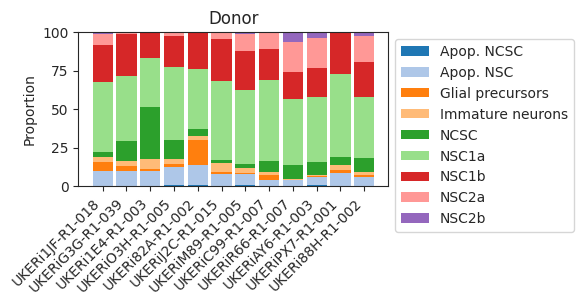

In [32]:
#Show an overview about cell type distributions across conditions as stacked barplot
pt.pl.coda.stacked_barplot(
    sccoda_data, modality_key="coda", feature_name='Donor', figsize=(4, 2)
)
plt.show()

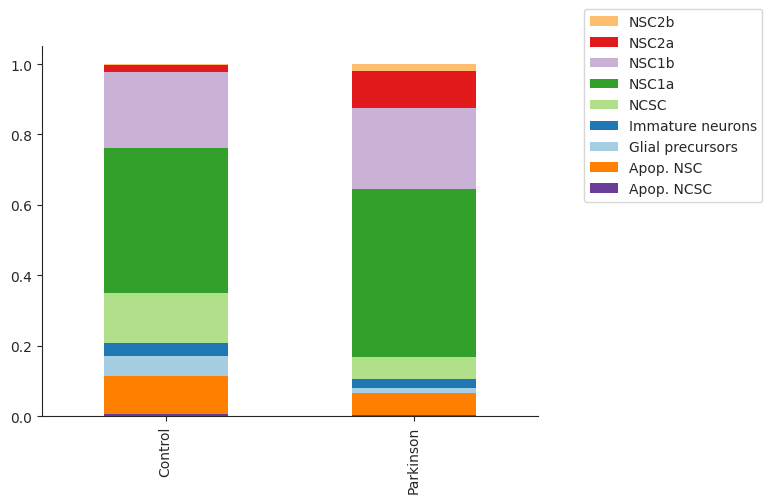

In [33]:
ax = pd.crosstab(adata.obs['condition'], adata.obs['cell_types'], normalize=0).plot(kind='bar', stacked=True, legend=False, color=col6, edgecolor='none')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.08,1.12,0,0), ncol=1)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.xlabel('')
plt.savefig('lp_NPCs/figures/Composition/cell_types_condition_celltype_composition.pdf', bbox_inches='tight')

plt.show()

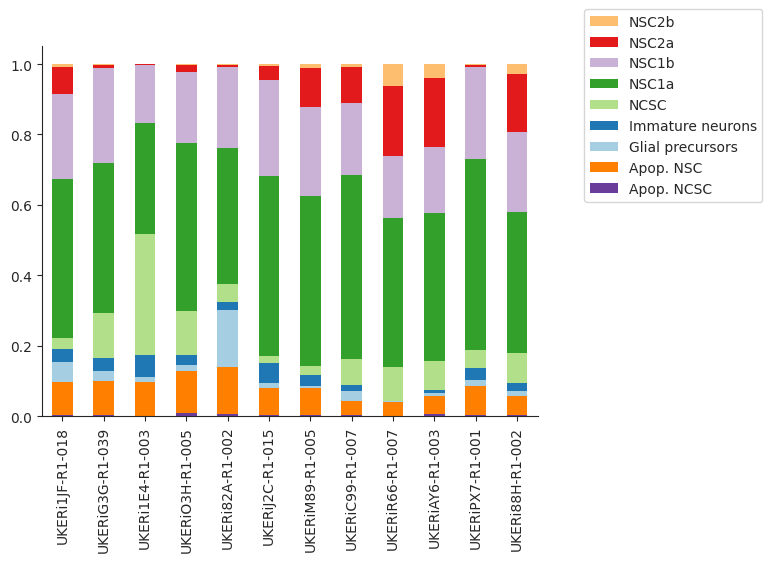

In [34]:
ax = pd.crosstab(adata.obs['Donor'], adata.obs['cell_types'], normalize=0).plot(kind='bar', stacked=True, legend=False, color=col6, edgecolor='none')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.08,1.12,0,0), ncol=1)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.xlabel('')
plt.savefig('lp_NPCs/figures/Composition/cell_types_Donor_celltype_composition.pdf', bbox_inches='tight')

plt.show()

In [35]:
col_donors = adata.uns['Donor_colors']

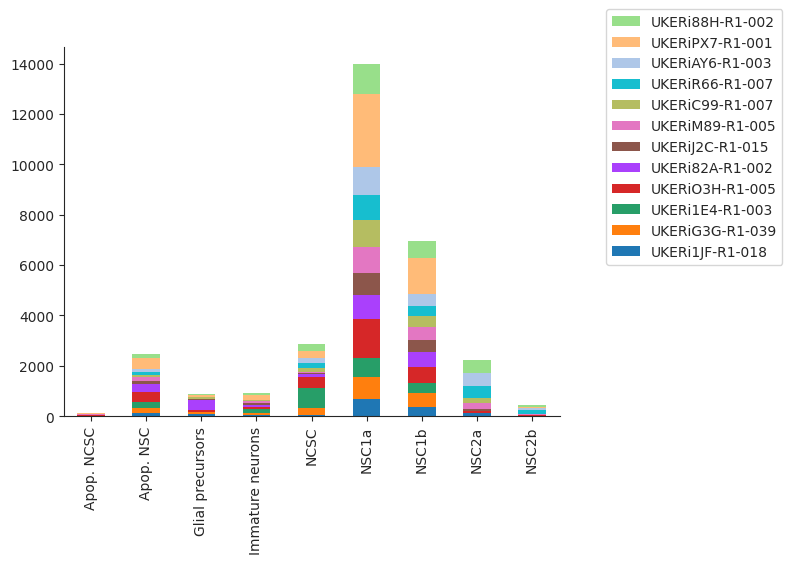

In [36]:
ax = pd.crosstab(adata.obs['cell_types'], adata.obs['Donor'], normalize=False).plot(kind='bar', stacked=True, legend=False, color=col_donors, edgecolor='none')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.08,1.12,0,0), ncol=1)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(False)
plt.xlabel('')
plt.savefig('lp_NPCs/figures/Composition/cell_types_Celltype_donor_composition_unnormalized.pdf', bbox_inches='tight')
plt.show()

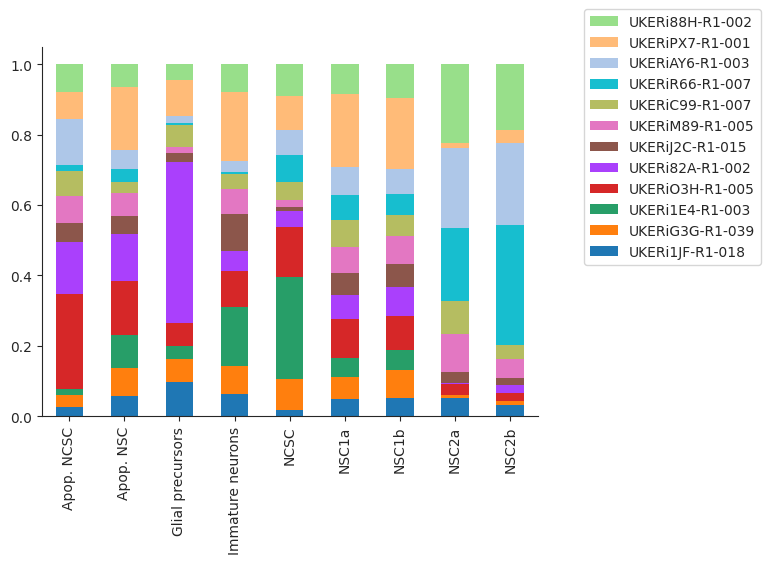

In [37]:
ax = pd.crosstab(adata.obs['cell_types'], adata.obs['Donor'], normalize=0).plot(kind='bar', stacked=True, legend=False, color=col_donors, edgecolor='none')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.08,1.12,0,0), ncol=1)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(False)
plt.xlabel('')
plt.savefig('lp_NPCs/figures/Composition/cell_types_Celltype_donor_composition.pdf', bbox_inches='tight')
plt.show()

In [38]:
col_condition = adata.uns['condition_colors']

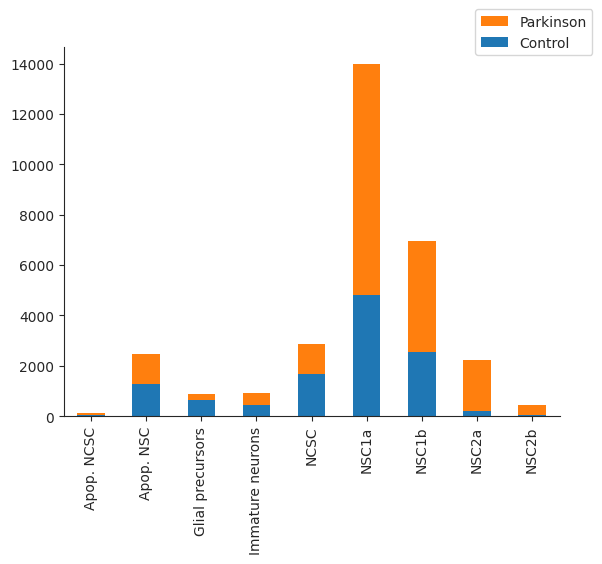

In [39]:
ax = pd.crosstab(adata.obs['cell_types'], adata.obs['condition'], normalize=False).plot(kind='bar', stacked=True, legend=False, color=col_condition, edgecolor='none')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.08,1.12,0,0), ncol=1)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(False)
plt.xlabel('')
plt.savefig('lp_NPCs/figures/Composition/cell_types_Celltype_condition_composition_unnormalized.pdf', bbox_inches='tight')
plt.show()

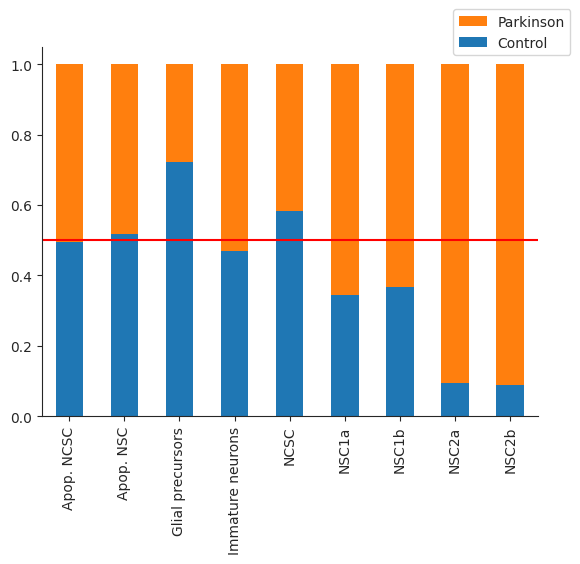

In [40]:
ax = pd.crosstab(adata.obs['cell_types'], adata.obs['condition'], normalize=0).plot(kind='bar', stacked=True, legend=False, color=col_condition, edgecolor='none')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.08,1.12,0,0), ncol=1)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(False)
plt.xlabel('')
plt.axhline(y=0.5, color='r', linestyle='-')
plt.savefig('lp_NPCs/figures/Composition/cell_types_Celltype_condition_composition.pdf', bbox_inches='tight')
plt.show()

## Run interference

In [41]:
sccoda_data_mod = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula="condition",
    reference_cell_type="automatic",
)
sccoda_model.run_nuts(sccoda_data_mod, modality_key="coda", rng_key=1234)

Automatic reference selection! Reference cell type set to Apop. NCSC

Zero counts encountered in data! Added a pseudocount of 0.5.

sample: 100%|███████████████████████| 11000/11000 [1:04:33<00:00,  2.84it/s, 255 steps of size 1.67e-02. acc. prob=0.87]


In [42]:
sccoda_data["coda"].varm["effect_df_condition[T.Parkinson]"]

,Final Parameter,HDI 3%,HDI 97%,SD,Inclusion probability,Expected Sample,log2-fold change
Cell Type,,,,,,,
Apop. NCSC,0.000000,0.000,0.000,0.000,0.0000,29.652816,-0.092915
Apop. NSC,0.000000,-0.962,0.181,0.297,0.5086,245.318437,-0.092915
Glial precursors,0.000000,-1.354,0.173,0.441,0.6336,89.349631,-0.092915
Immature neurons,0.000000,-1.030,0.393,0.304,0.4747,95.541156,-0.092915
NCSC,0.000000,-0.948,0.226,0.287,0.4907,227.137852,-0.092915
NSC1a,0.000000,-0.068,0.806,0.244,0.5317,1052.114376,-0.092915
NSC1b,0.000000,-0.316,0.709,0.193,0.3660,575.107575,-0.092915
NSC2a,1.279558,0.446,2.129,0.467,0.9868,222.097129,1.753097
NSC2b,0.000000,-0.186,1.537,0.497,0.6508,33.972695,-0.092915


## Select credible effects

The false discovery rate (FDR) was increased to 0.2.

In [43]:
sccoda_model.set_fdr(sccoda_data_mod, 0.2)

In [44]:
sccoda_model.credible_effects(sccoda_data_mod, modality_key="coda")

Covariate               Cell Type       
condition[T.Parkinson]  Apop. NCSC          False
                        Apop. NSC           False
                        Glial precursors    False
                        Immature neurons    False
                        NCSC                False
                        NSC1a               False
                        NSC1b               False
                        NSC2a                True
                        NSC2b                True
Name: Final Parameter, dtype: bool

## Visualize fold change

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  func(*plot_args, **plot_kwargs)


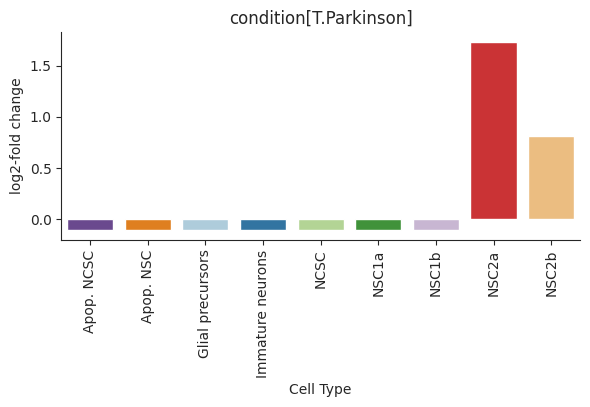

In [45]:
pt.pl.coda.effects_barplot(sccoda_data_mod, modality_key="coda", covariates="condition", cmap=col6)
plt.savefig('lp_NPCs/figures/Composition/cell_types_Celltype_composition_log2fc.pdf', bbox_inches='tight')
plt.show()

## Variation of the reference cell type

In [46]:
# Run scCODA with each cell type as the reference
cell_types = adata.obs.cell_types.cat.categories
results_cycle = pd.DataFrame(index=cell_types, columns=["times_credible"]).fillna(0)

for ct in cell_types:
    print(f"Reference: {ct}")

    # Run inference
    model_temp = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula="condition",
    reference_cell_type=ct,
    )
    sccoda_model.run_nuts(model_temp, modality_key="coda", rng_key=1234)
    
    # Select credible effects
    sccoda_model.set_fdr(model_temp, 0.2)
    cred_eff = sccoda_model.credible_effects(model_temp, modality_key="coda")
    cred_eff.index = cred_eff.index.droplevel(level=0)

    # add up credible effects
    results_cycle["times_credible"] += cred_eff.astype("int")

Reference: Apop. NCSC


sample: 100%|█████████████████████████| 11000/11000 [58:05<00:00,  3.16it/s, 255 steps of size 1.67e-02. acc. prob=0.87]


Reference: Apop. NSC


sample: 100%|█████████████████████████| 11000/11000 [56:28<00:00,  3.25it/s, 255 steps of size 1.87e-02. acc. prob=0.86]


Reference: Glial precursors


sample: 100%|██████████████████████████| 11000/11000 [33:23<00:00,  5.49it/s, 63 steps of size 2.84e-02. acc. prob=0.70]


Reference: Immature neurons


sample: 100%|█████████████████████████| 11000/11000 [56:16<00:00,  3.26it/s, 127 steps of size 1.81e-02. acc. prob=0.86]


Reference: NCSC


sample: 100%|█████████████████████████| 11000/11000 [55:28<00:00,  3.31it/s, 255 steps of size 1.80e-02. acc. prob=0.86]


Reference: NSC1a


sample: 100%|█████████████████████████| 11000/11000 [47:13<00:00,  3.88it/s, 255 steps of size 2.13e-02. acc. prob=0.87]


Reference: NSC1b


sample: 100%|█████████████████████████| 11000/11000 [48:41<00:00,  3.77it/s, 255 steps of size 1.96e-02. acc. prob=0.87]


Reference: NSC2a


sample: 100%|█████████████████████████| 11000/11000 [27:19<00:00,  6.71it/s, 127 steps of size 3.61e-02. acc. prob=0.78]


Reference: NSC2b


sample: 100%|█████████████████████████| 11000/11000 [50:46<00:00,  3.61it/s, 255 steps of size 2.02e-02. acc. prob=0.83]


In [47]:
# Calculate percentages
results_cycle["pct_credible"] = results_cycle["times_credible"]/len(cell_types)
results_cycle["is_credible"] = results_cycle["pct_credible"] > 0.5
print(results_cycle)



                  times_credible  pct_credible  is_credible
Apop. NCSC                     0      0.000000        False
Apop. NSC                      0      0.000000        False
Glial precursors               3      0.333333        False
Immature neurons               0      0.000000        False
NCSC                           0      0.000000        False
NSC1a                          0      0.000000        False
NSC1b                          0      0.000000        False
NSC2a                          8      0.888889         True
NSC2b                          5      0.555556         True
